In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from cpgan import init_yaml
from cpgan.eval.models_lib.ex6 import generator
import pandas as pd
from cpgan.ooppnm import img_process
from cpgan.ooppnm import pnm_sim
from cpgan.ooppnm import pnm_sim_old
import seaborn as sns 


import random
import porespy as ps
# random.seed(10)
# np.random.seed(10)

def kr_simulation(img_input,sim_num=100):
    data_pnm = pnm_sim.Pnm_sim(im=img_input)
    data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    data_pnm.init_physics()
    data_pnm.invasion_percolation()
    df_kr = data_pnm.kr_simulation(Snwp_num=sim_num)
    data_pnm.close_ws()
    return df_kr

def kabs_sim(img):
    data_pnm = pnm_sim_old.Pnm_sim(im=img)
    data_pnm.network_extract()
    if data_pnm.error == 1:
        return None
    data_pnm.init_physics()
    kabs = data_pnm.get_absolute_perm()
    data_pnm.close_ws()
    return kabs, data_pnm.data_tmp

def imgshow(im,sample_idx,z_idx):
    f = plt.figure()
    plt.imshow(im[sample_idx,0,z_idx,::])
    plt.show()

def plt_hist(fake,real,range_input,xlabel):
    # range input should be list
    f = plt.figure()
    plt.hist(real,range=range_input,density=True,bins=20,alpha=0.4,edgecolor='black',label='Original')
    plt.hist(fake,range=range_input,density=True,bins=20,alpha=0.4,edgecolor='black',label='Synthetic')
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

def plt_scatter(fake,real,range_input,xlabel):
    # range input should be list
    f = plt.figure()
    plt.scatter(real,fake)
    plt.xlim(range_input)
    plt.ylim(range_input)
    plt.xlabel("Original "+xlabel)
    plt.ylabel("Synthetic "+xlabel)
    plt.show()

def box_plot(fake,real,ylabel):
    phi_box = [fake, real]
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_axes([0, 0, 1, 1])

    bp = ax.boxplot(
        phi_box,
        boxprops=dict(linestyle='-', linewidth=2),
        whiskerprops=dict(linestyle='-', linewidth=2), 
        medianprops=dict(linestyle='-', linewidth=2), 
        capprops=dict(linestyle='-', linewidth=2)
            )

    ax.set_xticks([1,2],['Synthetic','Original'])
    ax.set_ylabel(ylabel)
    plt.show()

ex = 6
epoch = 20

# load model and features
f_yaml = init_yaml.yaml_f
gen_path = os.path.join(f_yaml['model'],"ex{}/cganex{}-{}.pth".format(ex,ex,epoch))
feature_path = os.path.join(f_yaml['feature_path'],'features.csv')
img_path = f_yaml['img_path']['img_chunk']

df = pd.read_csv(feature_path)
gen = generator.Generator(z_dim=200)
gen.load_state_dict(torch.load(gen_path,map_location=torch.device('cpu')))
gen.eval()

# load the simulation data for comparison
fake_data = pd.read_csv('data/df_fakeold_{}.csv'.format(ex))
real_data = pd.read_csv('data/df_realold_{}.csv'.format(ex))

sample_num = min(len(fake_data),len(real_data))
fake_data = fake_data.sample(sample_num)
real_data = real_data.sample(sample_num)

In [3]:
real_data.corr()

/tmp/ipykernel_3653707/818856609.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  real_data.corr()


,kabs,phi,eul,spec_area,psd,tsd,coord
kabs,1.000000,0.782755,-0.289798,0.502206,0.649501,0.653634,0.107768
phi,0.782755,1.000000,-0.529576,0.797730,0.672233,0.602268,0.081233
eul,-0.289798,-0.529576,1.000000,-0.765033,-0.247514,0.030073,0.006471
spec_area,0.502206,0.797730,-0.765033,1.000000,0.359801,0.153097,0.073319
psd,0.649501,0.672233,-0.247514,0.359801,1.000000,0.689452,0.085964
tsd,0.653634,0.602268,0.030073,0.153097,0.689452,1.000000,0.066356
coord,0.107768,0.081233,0.006471,0.073319,0.085964,0.066356,1.000000


In [4]:
fake_data.corr()

,kabs,phi,eul,spec_area,psd,tsd,coord
kabs,1.000000,0.767334,-0.282697,0.359562,0.560350,0.623860,0.680820
phi,0.767334,1.000000,-0.499412,0.661230,0.620268,0.633046,0.845177
eul,-0.282697,-0.499412,1.000000,-0.791203,-0.231656,0.039435,-0.638132
spec_area,0.359562,0.661230,-0.791203,1.000000,0.165585,-0.042656,0.634446
psd,0.560350,0.620268,-0.231656,0.165585,1.000000,0.727867,0.691786
tsd,0.623860,0.633046,0.039435,-0.042656,0.727867,1.000000,0.489575
coord,0.680820,0.845177,-0.638132,0.634446,0.691786,0.489575,1.000000


#### Try to evaluate GAN at different training stages

* correlation matrix heatmap

/tmp/ipykernel_3654133/2331339050.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = real_data.corr()


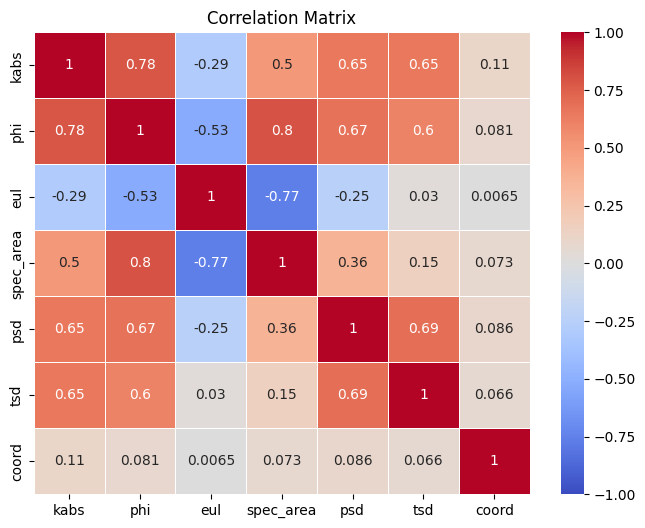

In [4]:
correlation_matrix = real_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

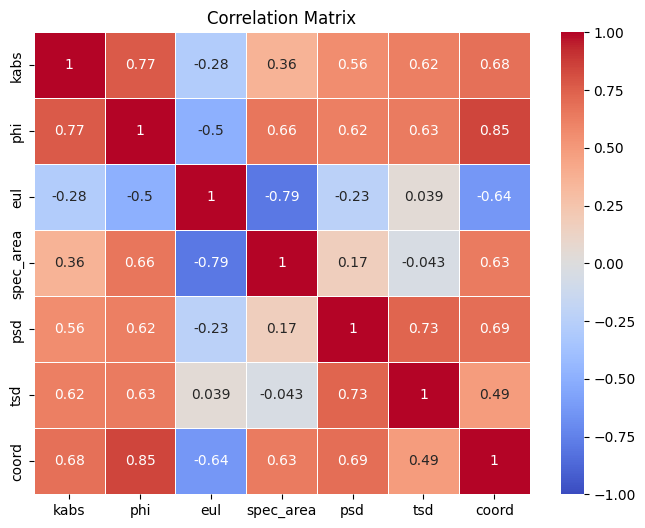

In [5]:
correlation_matrix = fake_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

#### box plot of reconstructed statistics vs training image statistics

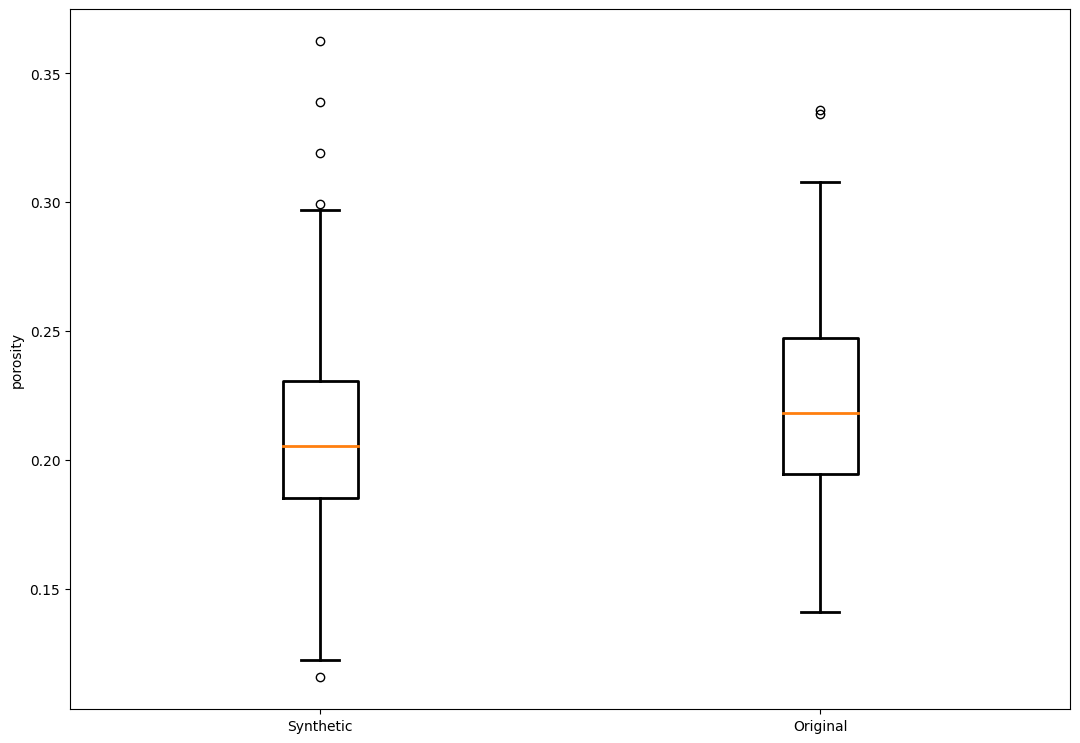

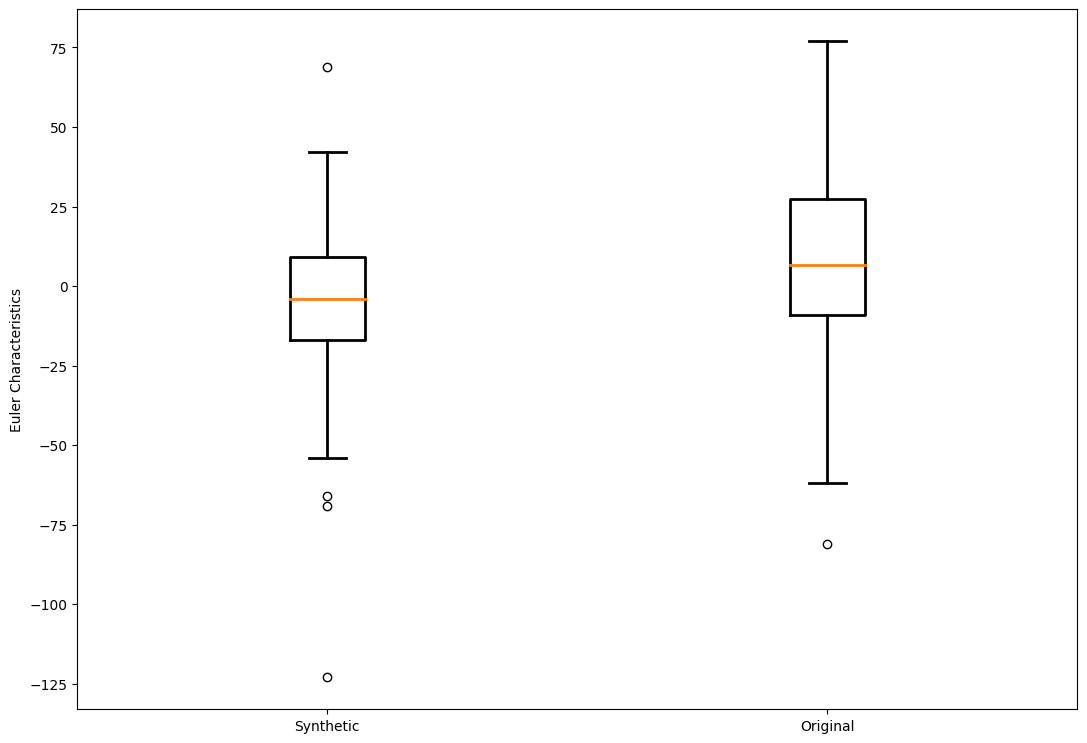

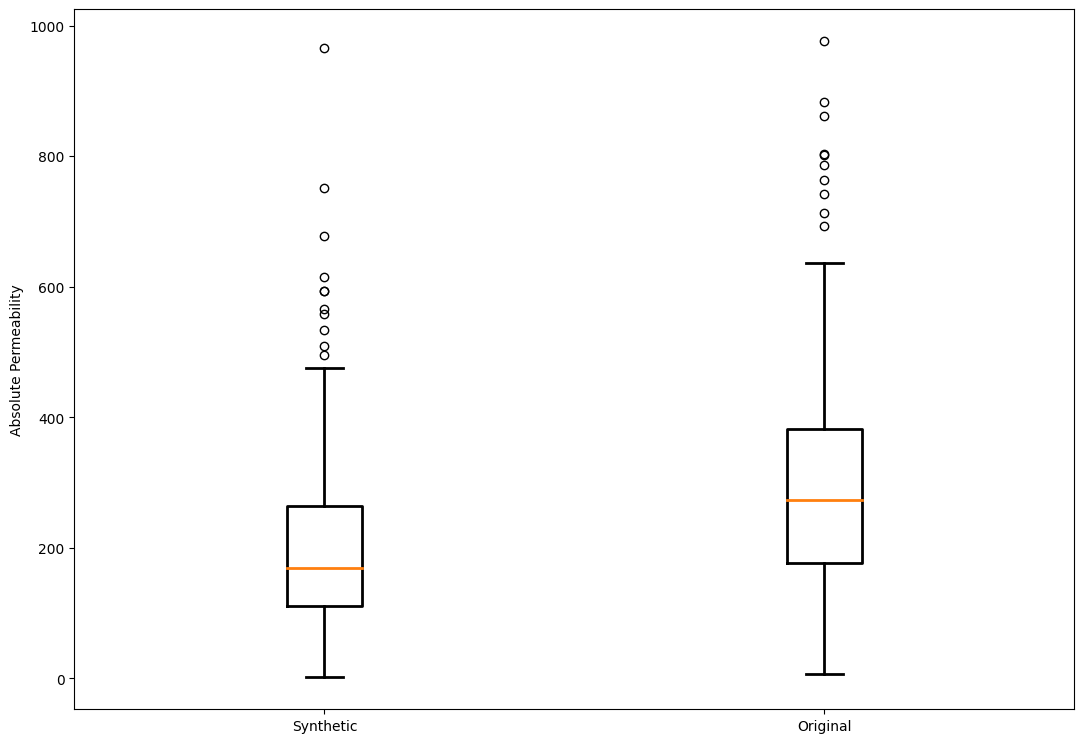

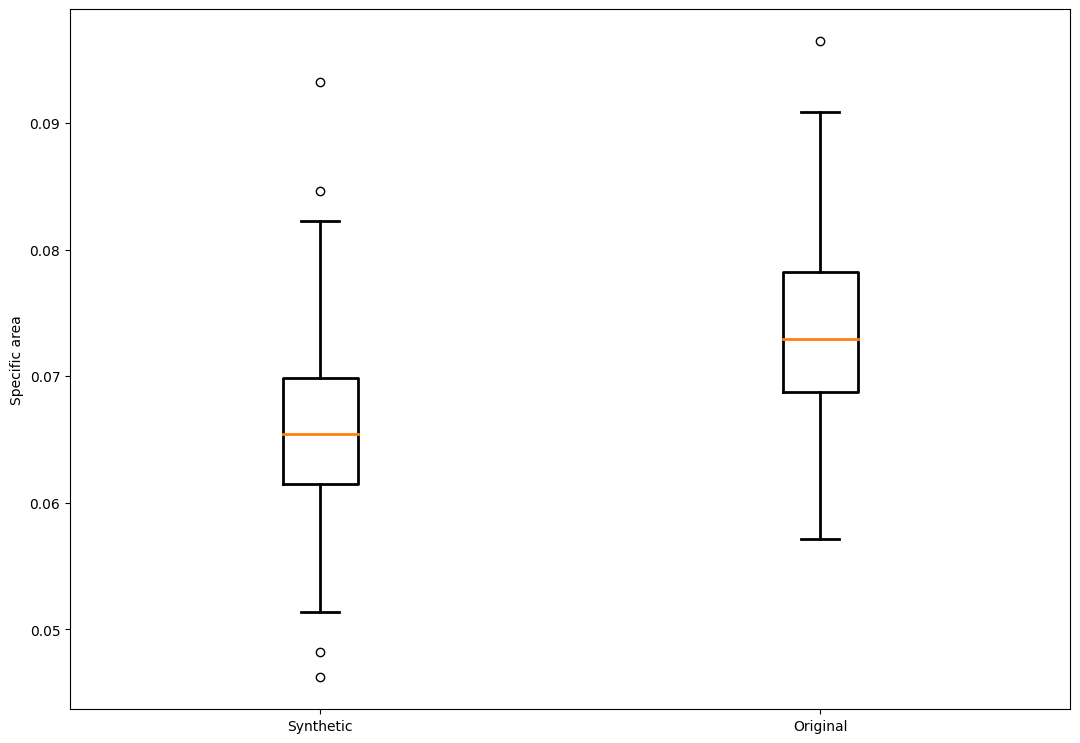

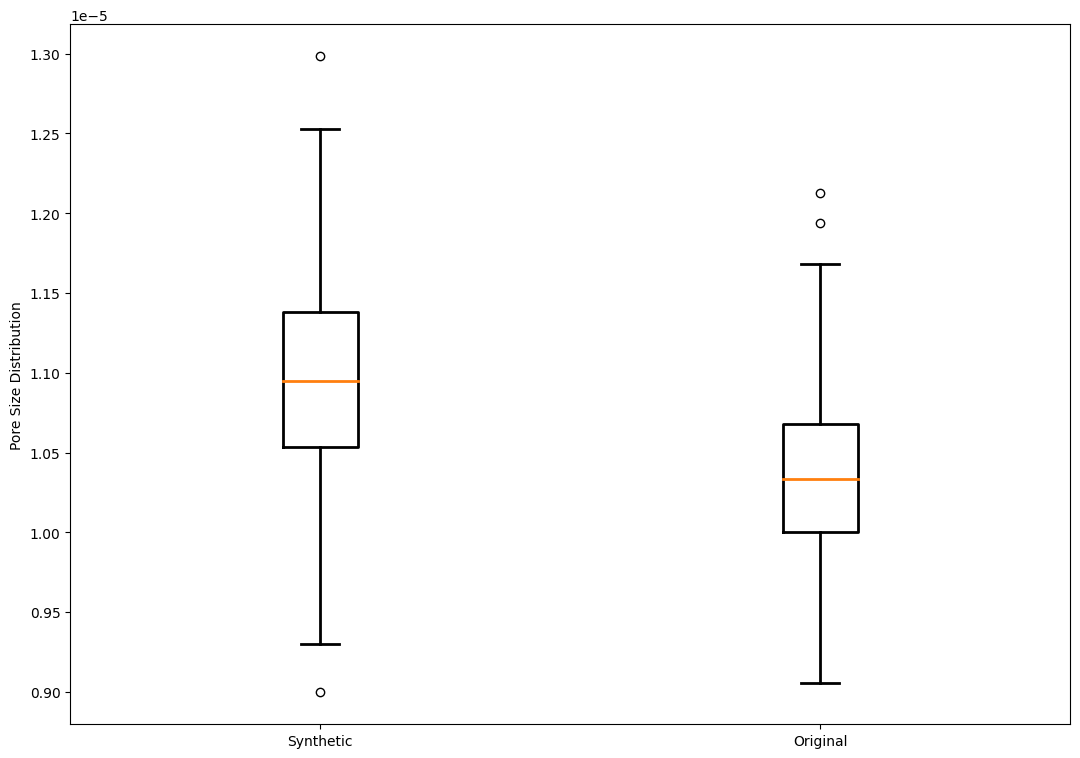

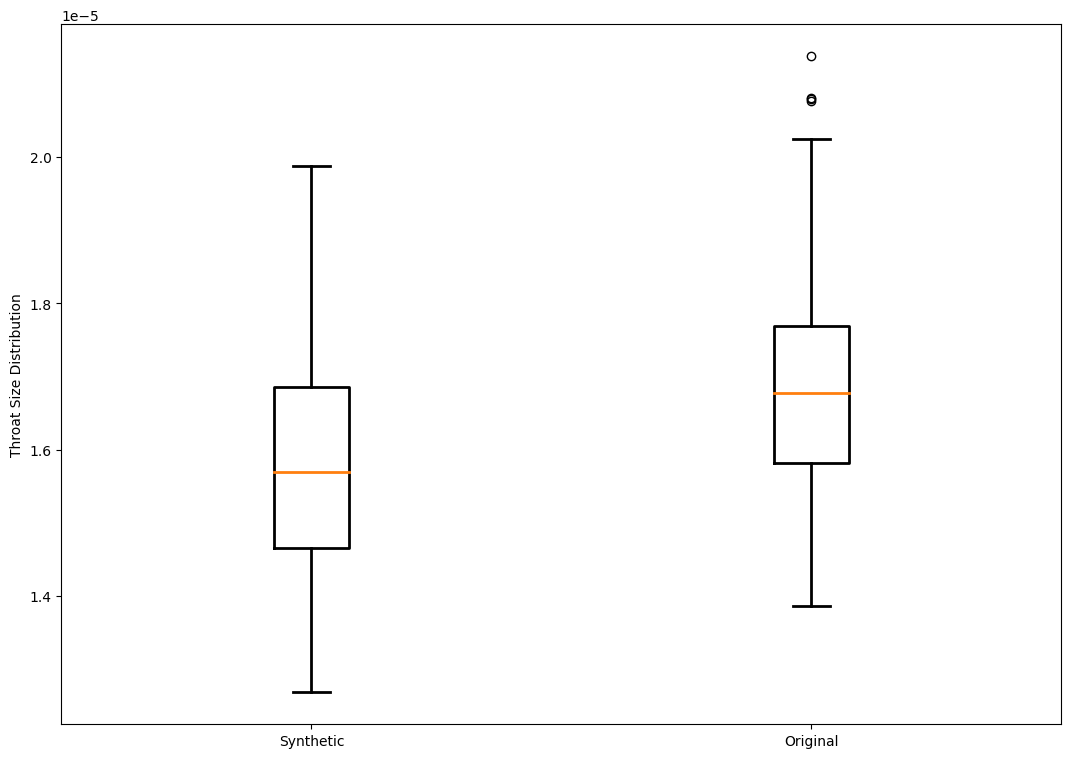

In [14]:
box_plot(fake_data['phi'].values,real_data['phi'].values,'porosity')
box_plot(fake_data['eul'].values,real_data['eul'].values,'Euler Characteristics')
box_plot(fake_data['kabs'].values,real_data['kabs'].values,'Absolute Permeability')
box_plot(fake_data['spec_area'].values,real_data['spec_area'].values,'Specific area')
box_plot(fake_data['psd'].values,real_data['psd'].values,'Pore Size Distribution')
box_plot(fake_data['tsd'].values,real_data['tsd'].values,'Throat Size Distribution')

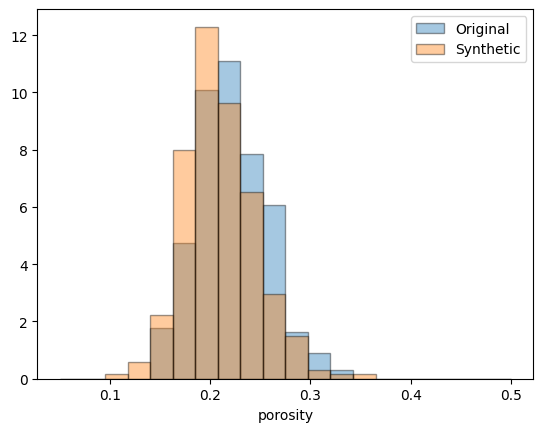

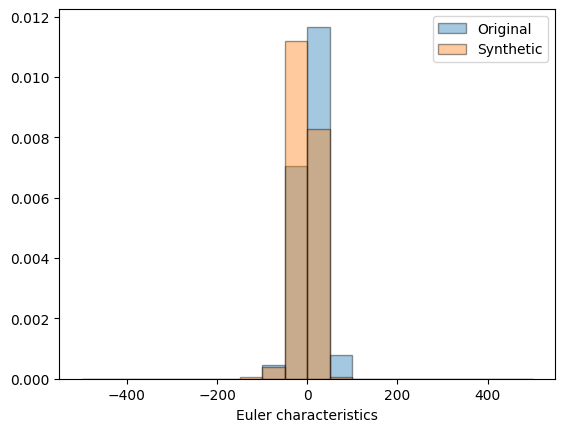

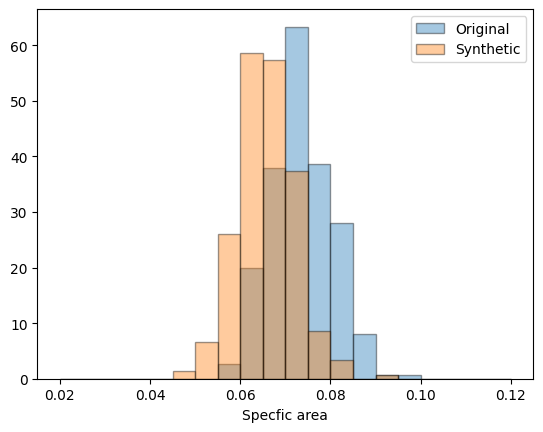

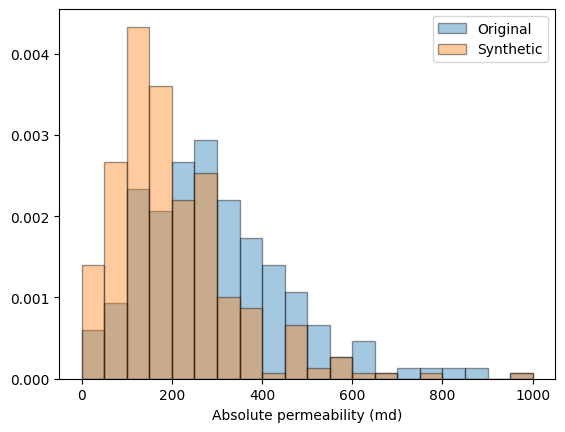

In [18]:
img_prc = img_process.Image_process()
plt_hist(
    fake_data['phi'].to_list(),real_data['phi'].to_list(),[0.05,0.5],'porosity'
    )

plt_hist(
    fake_data['eul'].to_list(),real_data['eul'].to_list(),[-500,500],'Euler characteristics'
)

plt_hist(
    fake_data['spec_area'].to_list(),real_data['spec_area'].to_list(),[0.02,0.12],'Specfic area'
)

plt_hist(
    fake_data['kabs'].to_list(),real_data['kabs'].to_list(),[0,1000],'Absolute permeability (md)'
)

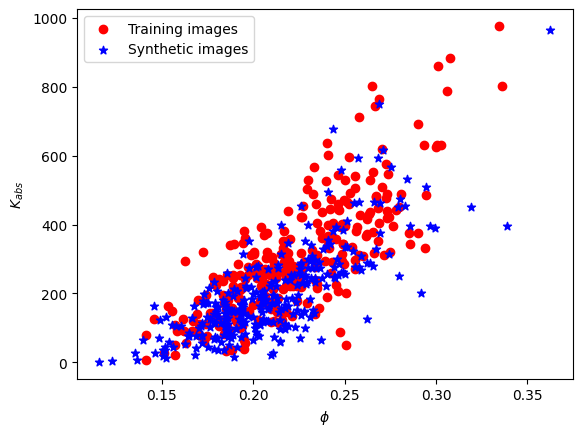

In [2]:
plt.scatter(real_data['phi'],real_data['kabs'],marker='o',c='r',label='Training images')
plt.scatter(fake_data['phi'],fake_data['kabs'],marker='*',c='b',label='Synthetic images')
plt.xlabel('$\phi$')
plt.ylabel('$K_{abs}$')
plt.legend()

#### Compare between fake vs real

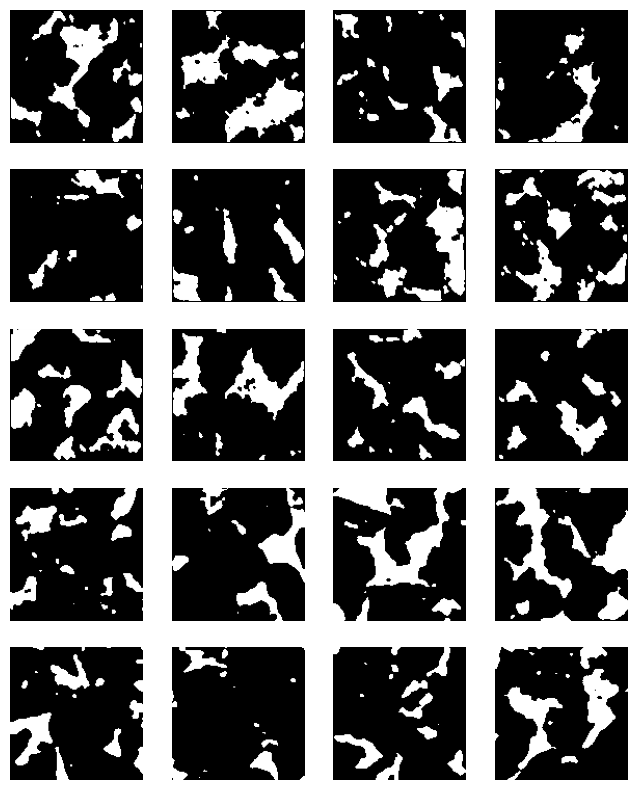

In [10]:
import random
def generate_img(sample_num):
    img=img_prc.clean_img(gen(torch.randn(sample_num,200)))
    return [img[i] for i in range(len(img))]

img_prc = img_process.Image_process()

f_yaml = init_yaml.yaml_f['img_path']['img_chunk']
PATH_img = [os.path.join(f_yaml,x) for x  in os.listdir(f_yaml)[:10000]]
random.shuffle(PATH_img)
real= [np.load(x) for x in PATH_img[:4]]
real1 = [np.load(x) for x in PATH_img[5:9]]

img_space = [generate_img(4),generate_img(4),generate_img(4),real1,real]
num_row = len(img_space)
num_col = 4

fig,axs = plt.subplots(num_row,num_col,figsize=(8,10))

for i in range(num_row):
    img_list = img_space[i]
    for j in range(num_col):
        img_sample = img_list[j][::,0]
        axs[i,j].imshow(img_sample,cmap='gray')
        axs[i,j].axis('off')

plt.show()

#### Interpolation between 2 gaussian vector

In [ ]:
# torch.manual_seed(15): reach the biggest discrepancy betweeo 2 porosity
torch.manual_seed(15)

img_prc = img_process.Image_process()

noise1 = torch.randn(1,200)
noise2 = torch.randn(1,200)

f_img1 = img_prc.clean_img(gen(noise1))
f_img2 = img_prc.clean_img(gen(noise2))

phi1 = img_prc.phi(f_img1)
phi2 = img_prc.phi(f_img2)

eul1 = img_prc.eul(f_img1[0])
eul2 = img_prc.eul(f_img2[0])

spec1 = img_prc.spec_suf_area(f_img1[0])
spec2 = img_prc.spec_suf_area(f_img2[0])

kabs1, other = kabs_sim(f_img1[0])
kabs2, other = kabs_sim(f_img2[0])

data1 = ps.metrics.two_point_correlation(f_img1[0],bins=50)
data2 = ps.metrics.two_point_correlation(f_img2[0],bins=50)

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.plot(data1.distance, data1.probability, 'r.',label='fake1')
ax.plot(data2.distance, data2.probability, 'b.',label='fake2')

ax.set_xlabel("distance")
ax.set_ylabel("two point correlation function")

#### construct the interpolated noise vector

In [3]:
n_interpolation = 10
percent_first_noise = np.linspace(0, 1, n_interpolation)[:, None]
interpolation_noise = noise1 * percent_first_noise + noise2 * (1 - percent_first_noise)
img_interp = gen(interpolation_noise.float())
img_interp = img_prc.clean_img(img_interp)


In [ ]:
phi_interp = []
eul_interp = []
spec_interp = []
kabs_interp = []
psd_interp = []
tsd_interp = []
for i in range(n_interpolation):
    phi_interp.append(img_prc.phi(img_interp[i]))
    eul_interp.append(img_prc.eul(img_interp[i]))
    spec_interp.append(img_prc.spec_suf_area(img_interp[i]))
    psd_tmp, tsd_tmp, kabs_tmp = kabs_sim(img_interp[i])
    kabs_interp.append(kabs_tmp)
    psd_interp.append(psd_tmp)
    tsd_interp.append(tsd_tmp)

#### See whether reconstructed statistics can be well constrained

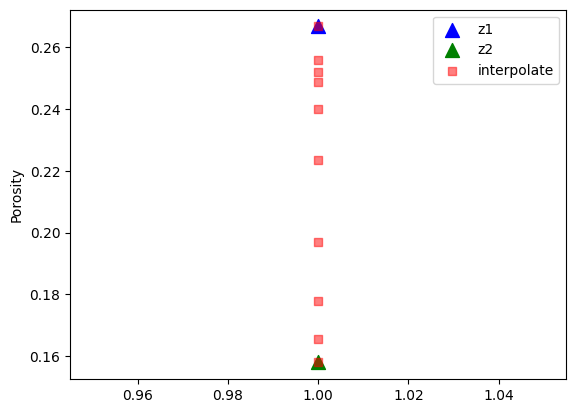

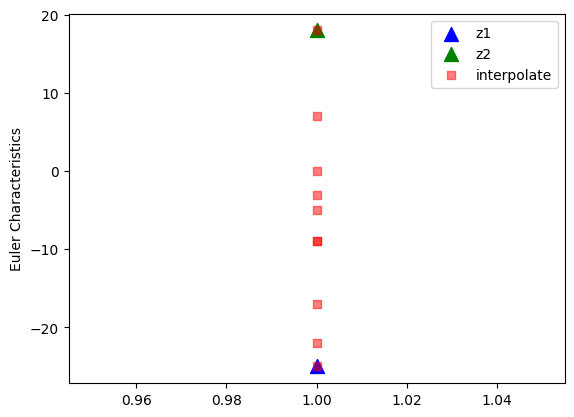

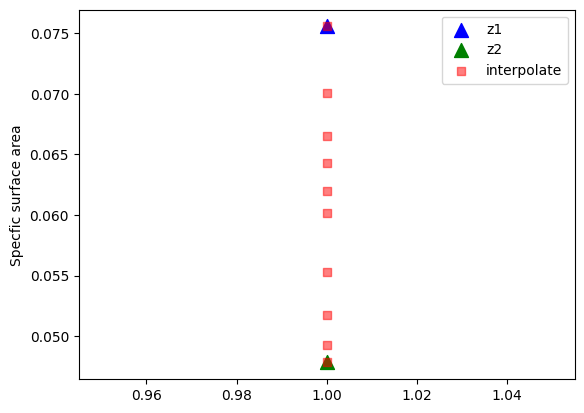

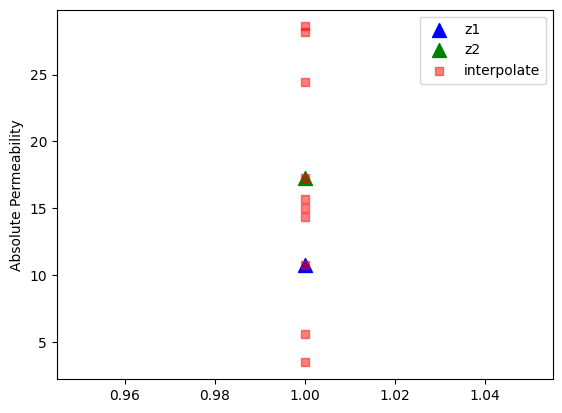

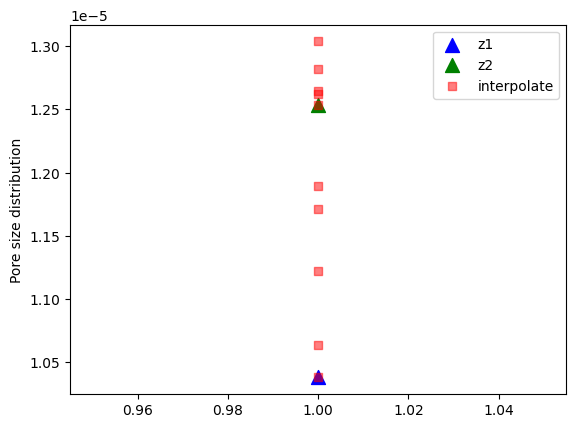

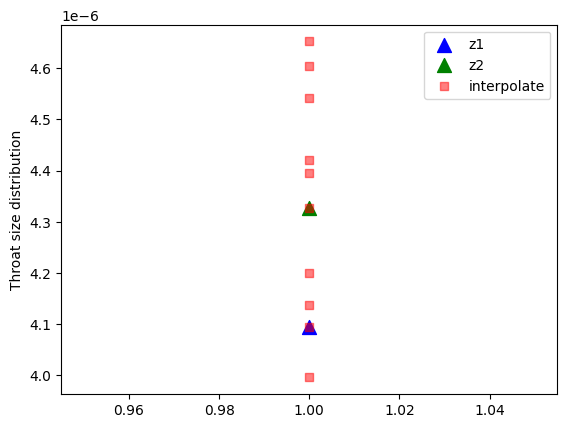

In [5]:
f, ax = plt.subplots()
ax.scatter([1],[phi1],100,c='b',marker='^',label='z1')
ax.scatter([1],[phi2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(phi_interp)).tolist(),phi_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Porosity")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[eul1],100,c='b',marker='^',label='z1')
ax.scatter([1],[eul2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(eul_interp)).tolist(),eul_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Euler Characteristics")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[spec1],100,c='b',marker='^',label='z1')
ax.scatter([1],[spec2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(spec_interp)).tolist(),spec_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Specfic surface area")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[kabs1],100,c='b',marker='^',label='z1')
ax.scatter([1],[kabs2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(kabs_interp)).tolist(),kabs_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Absolute Permeability")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[psd1],100,c='b',marker='^',label='z1')
ax.scatter([1],[psd2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(psd_interp)).tolist(),psd_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Pore size distribution")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[tsd1],100,c='b',marker='^',label='z1')
ax.scatter([1],[tsd2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(tsd_interp)).tolist(),tsd_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Throat size distribution")
ax.legend()

#### 2 point correlation

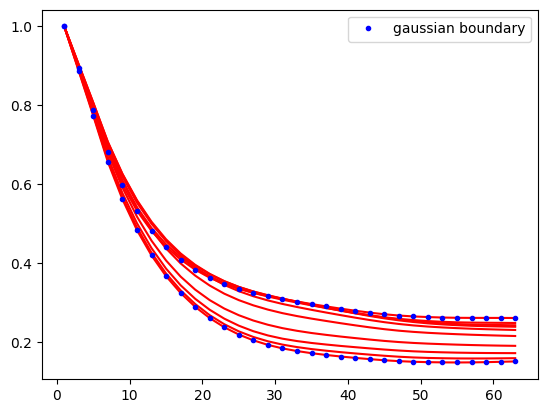

In [6]:
data_corr = []
for i in range(n_interpolation):
    data_corr.append( ps.metrics.two_point_correlation(img_interp[i],bins=50) )

f = plt.figure()
for i in range(n_interpolation):
    plt.plot(data_corr[i].distance,data_corr[i].probability,c='r')
plt.plot(data1.distance, data1.probability, 'b.',label='gaussian boundary')
plt.plot(data2.distance, data2.probability, 'b.')
plt.legend()

#### relative permeability interpolation

In [ ]:
dfkr1 = kr_simulation(f_img1[0])
dfkr2 = kr_simulation(f_img2[0])

data_kr_int = []
for i in range(n_interpolation):
    data_kr_int.append( kr_simulation(img_interp[i]) )

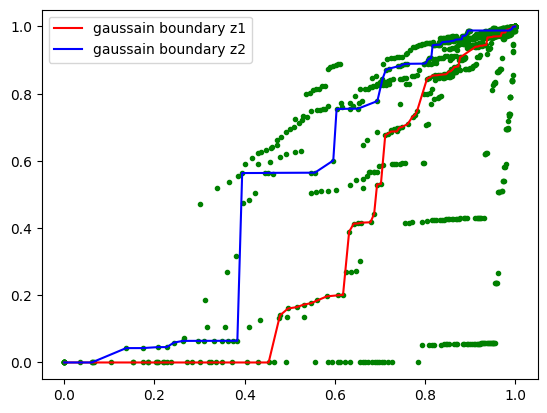

In [8]:
f = plt.figure()
for i in range(n_interpolation):
    plt.plot(data_kr_int[i]['snwp'],data_kr_int[i]['krnw'],'g.')
plt.plot(dfkr1['snwp'], dfkr1['krnw'],'r' ,label="gaussain boundary z1")
plt.plot(dfkr2['snwp'], dfkr2['krnw'],'b', label="gaussain boundary z2")
plt.legend()
plt.show()

#### control the generation and try to find which factors better constrain permeability

* test absolute perm

In [2]:
from cpgan.eval.util import z_perturb
img_prc = img_process.Image_process()
def kabs_sim(img):
    data_pnm = pnm_sim.Pnm_sim(im=img)
    _, _ = data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    kabs = data_pnm.cal_abs_perm()
    data_pnm.close_ws()
    return kabs

# optimize gaussian space into high perm and low perm.
eul_cal = img_prc.eul
opt = z_perturb.Z_perturb(gen,kabs_sim,100)
z_1,_,_ = opt.optimize(100,10,eta=1)
opt = z_perturb.Z_perturb(gen,kabs_sim,190)
z_2,_,_ = opt.optimize(100,10,eta=1)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/626 [00:00<?, ?it/s]

Epoch 0, error: 59.25064430915185                                     


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 1, error: 47.940961707473576                                    


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/739 [00:00<?, ?it/s]

Epoch 2, error: 56.105285255096135                                    


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 3, error: 5.417979859152382                                     


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 0, error: -59.22186621442344                                    


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/699 [00:00<?, ?it/s]

Epoch 1, error: -82.99909748939311                                    


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 2, error: -29.140385319357392                                   


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/527 [00:00<?, ?it/s]

Epoch 3, error: -6.553125079111936                                    


In [3]:
f_img1 = img_prc.clean_img(gen(z_1))
f_img2 = img_prc.clean_img(gen(z_2))
def kabs_sim(img):
    data_pnm = pnm_sim.Pnm_sim(im=img)
    psd, tsd = data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    kabs = data_pnm.cal_abs_perm()
    data_pnm.close_ws()
    return psd,tsd,kabs

In [ ]:
phi1 = img_prc.phi(f_img1[0])
phi2 = img_prc.phi(f_img2[0])

eul1 = img_prc.eul(f_img1[0])
eul2 = img_prc.eul(f_img2[0])

spec1 = img_prc.spec_suf_area(f_img1[0])
spec2 = img_prc.spec_suf_area(f_img2[0])

psd1, tsd1, kabs1 = kabs_sim(f_img1[0])
psd2, tsd2, kabs2 = kabs_sim(f_img2[0])

data1 = ps.metrics.two_point_correlation(f_img1[0],bins=50)
data2 = ps.metrics.two_point_correlation(f_img2[0],bins=50)

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.plot(data1.distance, data1.probability, 'r.',label='fake1')
ax.plot(data2.distance, data2.probability, 'b.',label='fake2')

ax.set_xlabel("distance")
ax.set_ylabel("two point correlation function")

In [6]:
n_interpolation = 10
percent_first_noise = np.linspace(0, 1, n_interpolation)[:, None]
interpolation_noise = z_1 * percent_first_noise + z_2 * (1 - percent_first_noise)
img_interp = gen(interpolation_noise.float())
img_interp = img_prc.clean_img(img_interp)

In [ ]:
phi_interp = []
eul_interp = []
spec_interp = []
kabs_interp = []
psd_interp = []
tsd_interp = []
for i in range(n_interpolation):
    phi_interp.append(img_prc.phi(img_interp[i]))
    eul_interp.append(img_prc.eul(img_interp[i]))
    spec_interp.append(img_prc.spec_suf_area(img_interp[i]))
    psd_tmp, tsd_tmp, kabs_tmp = kabs_sim(img_interp[i])
    kabs_interp.append(kabs_tmp)
    psd_interp.append(psd_tmp)
    tsd_interp.append(tsd_tmp)

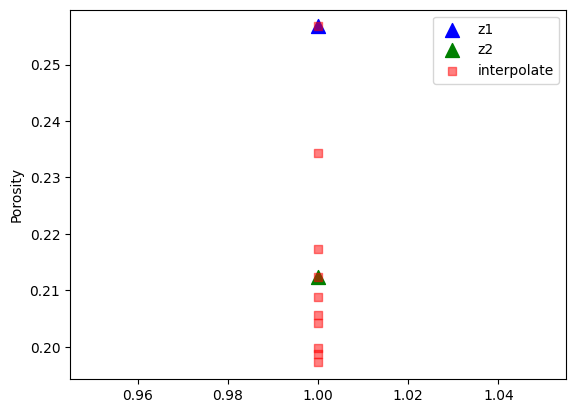

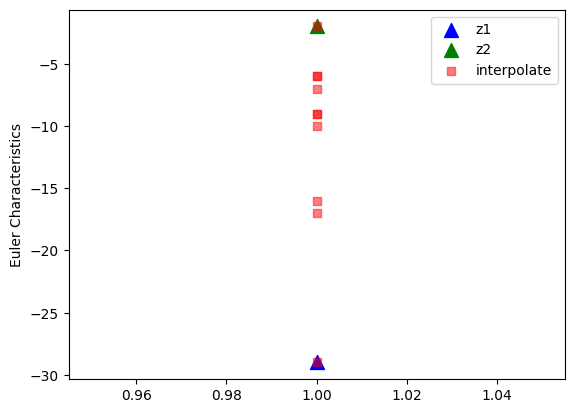

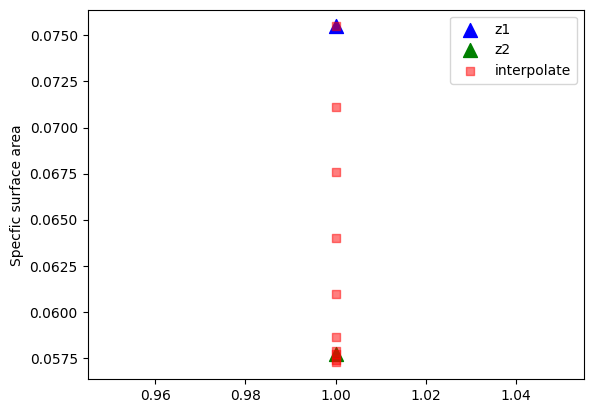

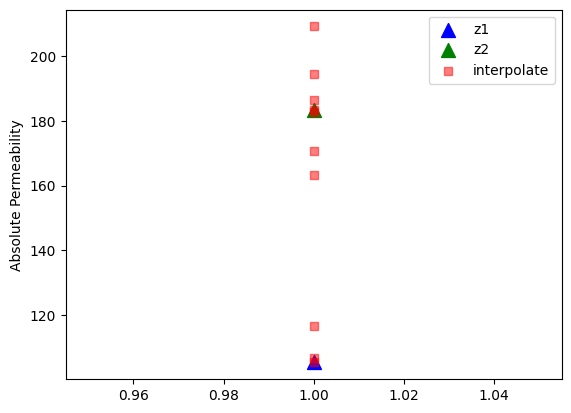

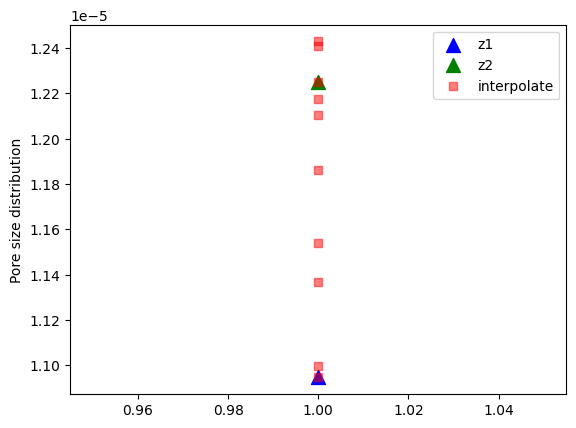

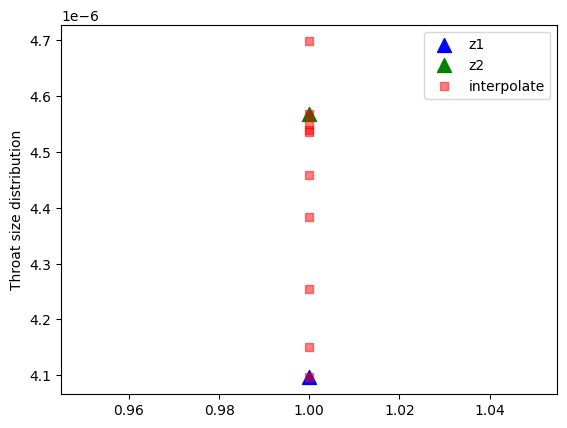

In [8]:
f, ax = plt.subplots()
ax.scatter([1],[phi1],100,c='b',marker='^',label='z1')
ax.scatter([1],[phi2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(phi_interp)).tolist(),phi_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Porosity")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[eul1],100,c='b',marker='^',label='z1')
ax.scatter([1],[eul2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(eul_interp)).tolist(),eul_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Euler Characteristics")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[spec1],100,c='b',marker='^',label='z1')
ax.scatter([1],[spec2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(spec_interp)).tolist(),spec_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Specfic surface area")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[kabs1],100,c='b',marker='^',label='z1')
ax.scatter([1],[kabs2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(kabs_interp)).tolist(),kabs_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Absolute Permeability")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[psd1],100,c='b',marker='^',label='z1')
ax.scatter([1],[psd2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(psd_interp)).tolist(),psd_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Pore size distribution")
ax.legend()

f, ax = plt.subplots()
ax.scatter([1],[tsd1],100,c='b',marker='^',label='z1')
ax.scatter([1],[tsd2],100,c='g',marker="^",label='z2')
ax.scatter(np.ones(len(tsd_interp)).tolist(),tsd_interp,marker='s',c='r',label='interpolate',alpha=0.5)
ax.set_ylabel("Throat size distribution")
ax.legend()

In [ ]:
dfkr1 = kr_simulation(f_img1[0])
dfkr2 = kr_simulation(f_img2[0])

data_kr_int = []
for i in range(n_interpolation):
    data_kr_int.append( kr_simulation(img_interp[i]) )

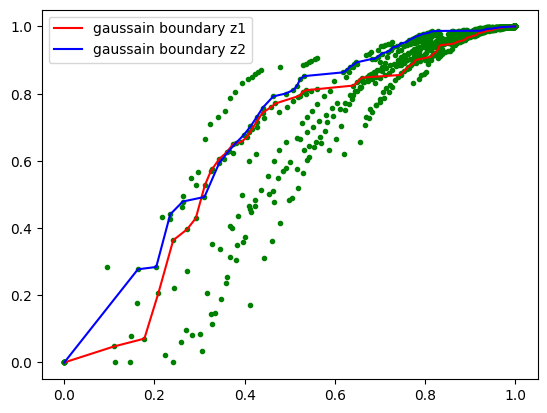

In [10]:
f = plt.figure()
for i in range(n_interpolation):
    plt.plot(data_kr_int[i]['snwp'],data_kr_int[i]['krnw'],'g.')
plt.plot(dfkr1['snwp'], dfkr1['krnw'],'r' ,label="gaussain boundary z1")
plt.plot(dfkr2['snwp'], dfkr2['krnw'],'b', label="gaussain boundary z2")
plt.legend()
plt.show()

#### Temporary conclusion:
* From the previous experiments, the absolute permeability is not linearly correlated with linear interpolation of gaussian space. The absolute permeability itself is highly non-linear correlated embedding gaussian space.
* Therefore, the spreading phenomenon in kr is reasonable. Absolute perm is far away from constraining $k_r$, even worse compariing with porosity
* The next step is to create a group of vectors z to understand what kind of factors really constrain $k$ motion. At the same time, we need to constrain $k$ and $\phi$ as a group variable the same time
* create a cluster map. Cluster $k$ and $\phi$ to different groups. Then plot kr to see any difference among the different group
* if $k$ and $\phi$ is not helpful in constraining the $k_r$, considering other factors like euler characteristics

#### Workflow procedure
* create a workflow to forcibly control the distribution of absolute perm. Then observe the trend of relative permeability;
* create a workflow to forcibly control the euler characteristics. Then observe the trend of relative permeability;
* generate 100 images. cluster them into different group of variables. observe the trend of relative permeability;

In [39]:
z = torch.randn(10,200)
k_list = []
f_image = gen(z)
f_image = img_filter(tensor_process(f_image))

def kabs_sim(img):
    data_pnm = pnm_sim.Pnm_sim(im=img)
    _, _ = data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    kabs = data_pnm.cal_abs_perm()
    data_pnm.close_ws()
    return kabs

In [ ]:
for i in range(len(z)):
    k_list.append(kabs_sim(f_image[i,0,::]))

In [ ]:
# find the min and max from a list
max_index = k_list.index(max(k_list))
min_index = k_list.index(min(k_list))
img1 = f_image[min_index][0]
img2 = f_image[max_index][0]
dfkr1 = kr_simulation(img1)
dfkr2 = kr_simulation(img2)

In [52]:
print(max(k_list))
print(min(k_list))


190.67795372633037
58.30002409701563


In [ ]:
data_kr_int = []
for i in range(len(f_image)):
    data_kr_int.append( kr_simulation( f_image[i,0,::]) )

#### constrain of absolute perm

* constrain of $k_{abs}$ actually gives a good constrain of kr
* what if we narrow the search space of kabs. Is $k_r$ still sensitive to change of $k_{abs}$?

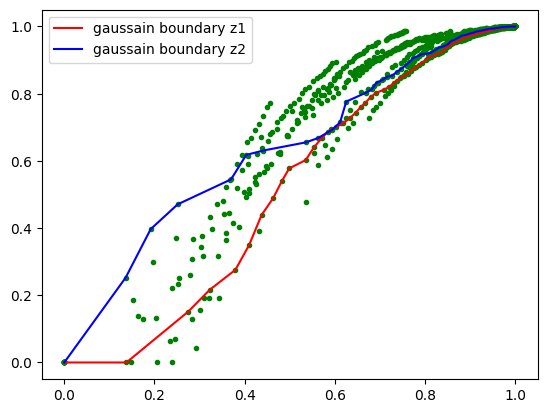

In [49]:
f = plt.figure()
for i in range(len(f_image)):
    plt.plot(data_kr_int[i]['snwp'],data_kr_int[i]['krnw'],'g.')
plt.plot(dfkr1['snwp'], dfkr1['krnw'],'r' ,label="gaussain boundary z1")
plt.plot(dfkr2['snwp'], dfkr2['krnw'],'b', label="gaussain boundary z2")
plt.legend()
plt.show()

#### now narrow your $k$ search space

* if we narrow k search space, the $k_r$ simulation result is less deterministics

In [2]:
# sort your list with only 
from cpgan.eval.util import z_perturb
img_prc = img_process.Image_process()
def kabs_sim(img):
    data_pnm = pnm_sim.Pnm_sim(im=img)
    _, _ = data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    kabs = data_pnm.cal_abs_perm()
    data_pnm.close_ws()
    return kabs

target_k = [i for i in range(100,150,5)]
pred_k = []
z_list = []

In [3]:
%%capture
for i in target_k:
    opt = z_perturb.Z_perturb(gen,kabs_sim,i)
    z_t,_,k_t = opt.optimize(100,10,eta=0.5)
    pred_k.append(k_t)
    z_list.append(z_t)

In [ ]:
## configure sorted z list
sort_idx = sorted(range(len(pred_k)),key=lambda idx: pred_k[idx])
z_s = [z_list[i] for i in sort_idx]
img1 = img_filter( tensor_process(gen(z_s[0])) )[0,0,::]
img2 = img_filter( tensor_process(gen(z_s[-1])) )[0,0,::]

dfkr1 = kr_simulation(img1)
dfkr2 = kr_simulation(img2)

data_kr_int = []
for i in range(1,len(z_s)-1):
    f_image = img_filter( tensor_process(gen(z_s[i])) )[0,0,::]
    data_kr_int.append( kr_simulation( f_image ) )

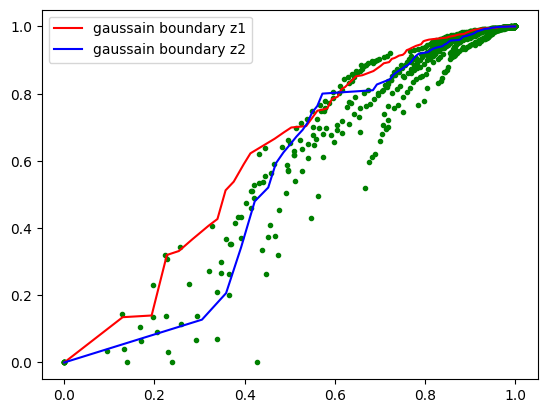

In [17]:
f = plt.figure()
for i in range(len(z_s)-2):
    plt.plot(data_kr_int[i]['snwp'],data_kr_int[i]['krnw'],'g.')
plt.plot(dfkr1['snwp'], dfkr1['krnw'],'r' ,label="gaussain boundary z1")
plt.plot(dfkr2['snwp'], dfkr2['krnw'],'b', label="gaussain boundary z2")
plt.legend()
plt.show()

In [26]:
## why the absolute perm can't constrain the boundary?
print(img_prc.phi(img1))
print(img_prc.phi(img2))
print(img_prc.eul(img1))
print(img_prc.eul(img2))
## the porosity and connectivity are really close, although absolute perm discrepancy is large

0.24810457229614258
0.1963357925415039
-14
-22


#### Constrain euler characteristics

#### now try to constrain multiple factors at the same time

In [5]:
img_prc = img_process.Image_process()

def multivar_opt(phi_target,eul_target,eta=0.5,epoch=100):

    def kabs_sim(img):
        data_pnm = pnm_sim.Pnm_sim(im=img)
        _, _ = data_pnm.network_extract()
        data_pnm.add_boundary_pn()
        kabs = data_pnm.cal_abs_perm()
        data_pnm.close_ws()
        return kabs

    def tensor_process(image_tensor):

        image_unflat = image_tensor.detach().cpu()
        image_numpy = image_unflat.numpy()

        return image_numpy>0.5

    def img_phy_qual(im):
        eul_im = img_prc.eul(im)
        if abs(eul_im)<500:
            return True
        else:
            return False

    def imgshow(im,sample_idx,z_idx):
        f = plt.figure()
        plt.imshow(im[sample_idx,0,z_idx,::])
        plt.show()

    def grad_cal(err,z1,z2,t):
        err = torch.Tensor([err])
        grad = err * (-z1*torch.sin(t)+z2*torch.cos(t))
        return torch.mean(grad)

    def grad_update(grad,t,eta):
        t -= eta*grad
        return t

    def compound_vec(z1,z2,t):
        z_n = z1*torch.cos(t) + z2*torch.sin(t)
        return z_n

    def forward_img(z_n,gen):
        gen.eval()
        img = gen(z_n)
        return img[0,0,::]

    z_n = torch.randn(1,200)
    t = torch.Tensor([0.5])
    err_list_phi = []
    err_list_k = []
    eta = 0.1

    for i in range(epoch):
        z2 = torch.randn(1,200)
        z_n = compound_vec(z_n,z2,t)
        img = forward_img(z_n,gen)
        img = tensor_process(img)
        phi_pred = img_prc.phi(img)
        eul_pred = img_prc.eul(img)
        # k_pred = kabs_sim(img)
        err_phi = phi_pred - phi_target
        err_eul = eul_pred - eul_target
        print(f'Epoch {i}, error eul: {err_eul}')
        print(f'Epoch {i}, error phi: {err_phi}')

        grad_t_phi = grad_cal(err_phi,z_n,z2,t)
        grad_t_k = grad_cal(err_eul/80,z_n,z2,t)

        err_phi_a = abs(err_phi)
        err_eul_a = abs(err_eul)
        
        t = grad_update(grad_t_phi + grad_t_k,t,eta)
        z_n = compound_vec(z_n,z2,t)

        if ((err_phi_a<0.02) & (err_eul_a<10)):
            return z_n, phi_pred, eul_pred
        
    return z_n,phi_pred,eul_pred


In [6]:
target_phi = [i/100 for i in range(15,30,2)]
target_eul = [50,30,10,-10,-30,-50,-70,-90]
z_list = []
pred_phi_rs = []
pred_eul_rs = []

In [ ]:
for i,j in zip(target_phi,target_eul):
    z_tmp,pred_phi_tmp,pred_eul_tmp = multivar_opt(i,j)
    z_list.append(z_tmp)
    pred_phi_rs.append(pred_phi_tmp)
    pred_eul_rs.append(pred_eul_tmp)


In [16]:
z = torch.randn(10,200)
k_list = []
f_image = gen(z)
f_image = img_filter(tensor_process(f_image))

In [17]:
phi_list = []
eul_list = []

for i in range(len(f_image)):
    phi_list.append( img_prc.phi(f_image[i][0,::]) )
    eul_list.append( img_prc.eul(f_image[i][0,::]) )

In [18]:
phi_list

[0.2248821258544922,
 0.18915557861328125,
 0.21001577377319336,
 0.23313331604003906,
 0.1632676124572754,
 0.22530460357666016,
 0.22081995010375977,
 0.2696809768676758,
 0.22895002365112305,
 0.14937686920166016]

In [19]:
eul_list

[61, -960, -11, -9, 23, -25, -107, 23, -9, -3]

In [2]:
# sort your list with only 
from cpgan.eval.util import z_perturb
img_prc = img_process.Image_process()

target_eul = [-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50]
eul_sim = img_prc.eul
pred_eul = []
z_list = []

In [3]:
%%capture
for i in target_eul:
    opt = z_perturb.Z_perturb(gen,eul_sim,i)
    z_t,_,e_t = opt.optimize(100,10,eta=0.5)
    pred_eul.append(e_t)
    z_list.append(z_t)

In [ ]:
## configure sorted z list
sort_idx = sorted(range(len(pred_eul)),key=lambda idx: pred_eul[idx])
z_s = [z_list[i] for i in sort_idx]
img1 = img_filter( tensor_process(gen(z_s[0])) )[0,0,::]
img2 = img_filter( tensor_process(gen(z_s[-1])) )[0,0,::]

dfkr1 = kr_simulation(img1)
dfkr2 = kr_simulation(img2)

data_kr_int = []
for i in range(1,len(z_s)-1):
    f_image = img_filter( tensor_process(gen(z_s[i])) )[0,0,::]
    data_kr_int.append( kr_simulation( f_image ) )

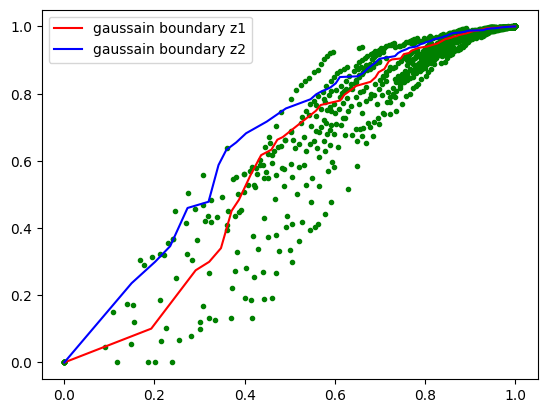

In [13]:
f = plt.figure()
for i in range(len(z_s)-2):
    plt.plot(data_kr_int[i]['snwp'],data_kr_int[i]['krnw'],'g.')
plt.plot(dfkr1['snwp'], dfkr1['krnw'],'r' ,label="gaussain boundary z1")
plt.plot(dfkr2['snwp'], dfkr2['krnw'],'b', label="gaussain boundary z2")
plt.legend()
plt.show()